# ***PROBLEM STATEMENT***

The objective of this project is to predict **room occupancy status** using sensor data collected from the **Intel Berkeley Research Lab**. The data includes time-series environmental readings such as:

- Temperature  
- Humidity  
- Light intensity  
- Voltage

However, the dataset does **not directly contain occupancy labels**. Therefore, the problem extends beyond standard classification:

1. **Generate meaningful occupancy labels** from available signals.
2. **Evaluate model performance** in the presence of real-world noise and class imbalance.
3. Design models that are **robust and responsive**, particularly in safety-critical contexts where **false negatives must be minimized**.

The final goal is to compare the behavior of supervised and unsupervised learning techniques (Random Forest and K-Means) when subjected to imperfect, noisy data — and to understand the trade-offs between **accuracy**, **recall**, and **false alarms** in realistic applications.


Importing all required libraries.

In [1]:
# For Data Handling
import numpy as np
import pandas as pd

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Data Precessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# For Training Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, classification_report, roc_auc_score, roc_curve

Importing the dataset and explicitly assigning column headers.

In [2]:
url = "http://db.csail.mit.edu/labdata/data.txt.gz"

df = pd.read_csv(url, sep=" ", names=["date", "time", "epoch", "mote_id", "temperature", "humidity", "light", "voltage"])

df.head()

,date,time,epoch,mote_id,temperature,humidity,light,voltage
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


Checking the duplicate rows in dataset to drop if any.

In [3]:
df.duplicated().sum()

np.int64(0)

As number of duplicates are zero, so we won't drop any rows.

In [4]:
df.dropna(how='any', inplace = True)

### Defining new parameters

In [5]:
df['occupancy_noise'] = ((df['temperature'] > 18) & (df['humidity'] > 35) & (df['light'] > 250) ^ (np.random.rand(len(df)) < 0.1)).apply(lambda x: 1 if x else 0).astype(int) # For Random Forest Classifier (Supervised)
df['occupancy'] = ((df['temperature'] > 18) & (df['humidity'] > 35) & (df['light'] > 250)).apply(lambda x: 1 if x else 0).astype(int) # For K Means Clustering (Unsupervised)

To evaluate model robustness and avoid overfitting (cramming), different preprocessing approaches were used for different algorithms:

  - 🌲  Random Forest Classifier (`occupancy_noise`):
A controlled 10% bit-flip noise was added to one of the key features. This helps the model generalize better by reducing the risk of memorizing patterns too strictly, which can lead to cramming.

  - 🔘  K-Means Clustering (`occupancy`):
The same feature was used without any added noise, ensuring the clustering algorithm receives the original distribution for better unsupervised learning performance.

Getting counts for both parameters.

In [6]:
display(df['occupancy_noise'].value_counts())
display(df['occupancy'].value_counts())

,count
occupancy_noise,
0,1623759
1,596044


,count
occupancy,
0,1752783
1,467020


### Splitting the dataset between training and test set.

In [7]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

Summary of training dataset.

In [8]:
train_df.describe()

,epoch,mote_id,temperature,humidity,light,voltage,occupancy_noise,occupancy
count,1.487268e+06,1.487268e+06,1.487268e+06,1.487268e+06,1.487268e+06,1.487268e+06,1.487268e+06,1.487268e+06
mean,3.302128e+04,2.847367e+01,3.924183e+01,3.373575e+01,4.074977e+02,2.490595e+00,2.690013e-01,2.104832e-01
std,1.837522e+04,1.503301e+01,3.742501e+01,1.616849e+01,5.396959e+02,1.783887e-01,4.434408e-01,4.076520e-01
min,0.000000e+00,1.000000e+00,-3.840000e+01,-1.854520e+03,3.077160e-15,9.100830e-03,0.000000e+00,0.000000e+00
25%,1.760000e+04,1.700000e+01,2.045880e+01,3.184240e+01,3.956000e+01,2.385220e+00,0.000000e+00,0.000000e+00
50%,3.330500e+04,2.900000e+01,2.246780e+01,3.921230e+01,1.582400e+02,2.527320e+00,0.000000e+00,0.000000e+00
75%,4.776000e+04,4.100000e+01,2.698560e+01,4.348570e+01,5.667200e+02,2.627960e+00,1.000000e+00,0.000000e+00
max,6.553500e+04,5.800000e+01,3.855680e+02,1.375120e+02,1.847360e+03,3.159150e+00,1.000000e+00,1.000000e+00


## Data Visualization

### Plotting a boxplot between `Occupany` & `Temperature`on a training dataset.

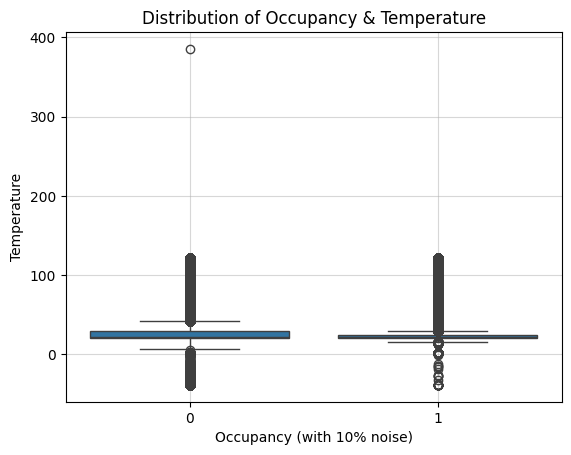

In [9]:
sns.boxplot(x='occupancy_noise', y='temperature', data=train_df)
plt.xlabel('Occupancy (with 10% noise)')
plt.ylabel('Temperature')
plt.title('Distribution of Occupancy & Temperature')
plt.grid(alpha=0.5)
plt.show()

Temperature alone does not clearly separate occupied and unoccupied rooms — though there are some small differences that a model might still use.

### A Histogram of `Temperature`.

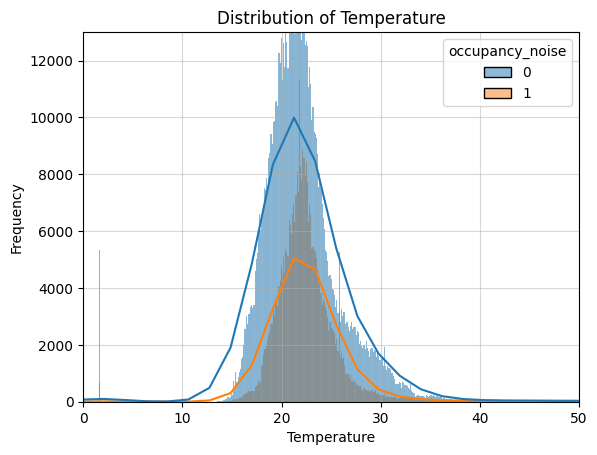

In [10]:
sns.histplot(x='temperature', data=train_df, hue='occupancy_noise', kde=True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature')
plt.ylim(0, 13000)
plt.xlim(0, 50)
plt.grid(alpha=0.5)
plt.show()

Occupied and unoccupied rooms have very similar temperatures, so temperature alone won't clearly separate them. But the model may still find some small patterns.

### A Histogram on `Humidity`.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


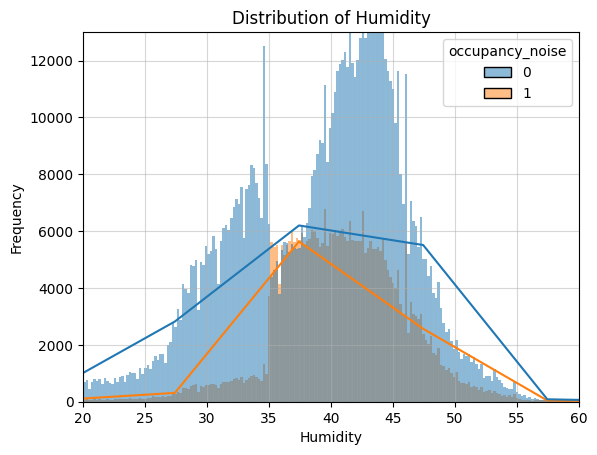

In [11]:
sns.histplot(x='humidity', data=train_df, hue='occupancy_noise', kde=True)
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Distribution of Humidity')
plt.xlim(20, 60)
plt.ylim(0, 13000)
plt.grid(alpha=0.5)
plt.show()

Humidity might be a better indicator of occupancy than temperature, but it’s still not perfectly clear. The model can likely learn from this difference.

### Correlation Matrix.

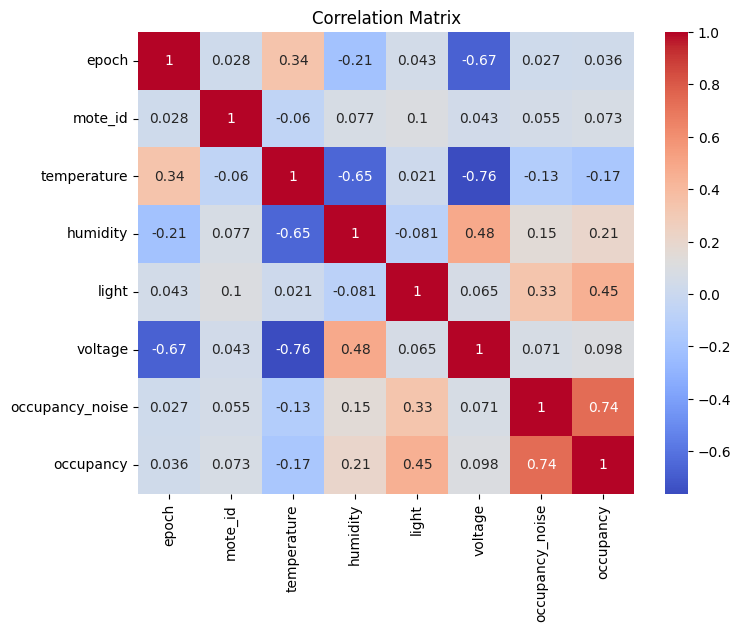

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(test_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- Humidity and light are more helpful in predicting occupancy than temperature or voltage.

- Temperature alone is not a strong signal, which matches what we saw in earlier plots.

- Models like Random Forest can benefit from using humidity and light as main features.

Scaling the required columns of dataset.

In [13]:
scaler = RobustScaler()

cols_to_scale = ['epoch', 'mote_id', 'temperature', 'humidity', 'light', 'voltage']
train_df_scaled = scaler.fit_transform(train_df[cols_to_scale])
test_df_scaled = scaler.transform(test_df[cols_to_scale])

Defining separate datasets for model training and evaluation by partitioning the original dataset for `Random Forest Classification`.

In [14]:
X_train = train_df_scaled
y_train1= train_df['occupancy_noise']

X_test = test_df_scaled
y_test1 = test_df['occupancy_noise']

## Prediction Models

### Random Forest Classifier

Training & Predicting the data.

In [15]:
model1 = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=1, class_weight='balanced')
model1.fit(X_train, y_train1)

y_proba = model1.predict_proba(X_test)[:, 1]
y_pred1 = (y_proba > 0.50).astype(int)

Calculating Accuracy Score for `Random Forest Classifier`.

In [16]:
acc11 = accuracy_score(y_test1, y_pred1)
# Flip the predicted labels: 1 → 0, 0 → 1
# This ensures the predictions match the intended label definitions
acc12 = accuracy_score(y_test1, 1 - y_pred1)

# We would consider the best accuracy score among both.
print("Accuracy:", max(acc11, acc12))

Accuracy: 0.7912700417044919


#### Plotting an Confusion Matrix on `Random Forest model`.

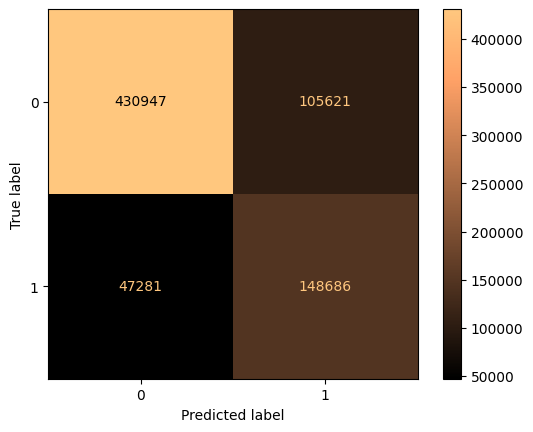

In [17]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, y_pred1)).plot(cmap='copper')
plt.show()

Obtaining the `classification report` to assess `Random Forest Classifier` performance using `precision`, `recall`, and `F1-score`.

In [18]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85    536568
           1       0.58      0.76      0.66    195967

    accuracy                           0.79    732535
   macro avg       0.74      0.78      0.75    732535
weighted avg       0.82      0.79      0.80    732535



Calculating the `ROC-AUC Score` for `Random Forest Classifier`.

In [19]:
roc1 = roc_auc_score(y_test1, y_pred1)
roc1

np.float64(0.7809421395687086)

#### Plotting an `ROC Curve` for `Random Forest Classifier`.

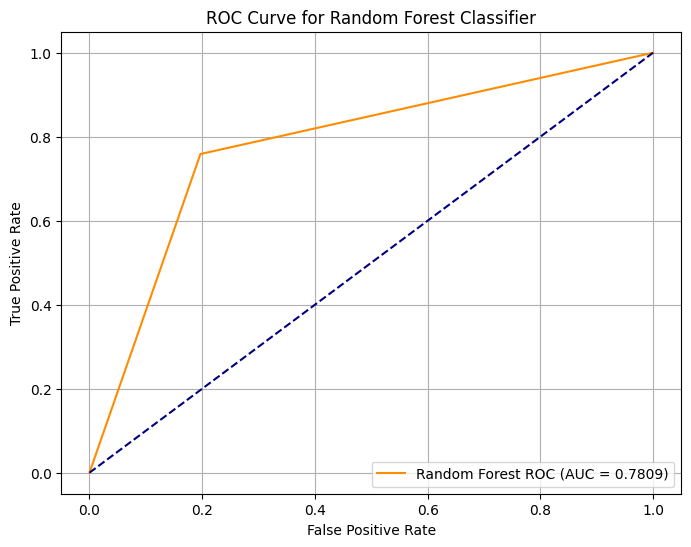

In [20]:
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1)
roc_auc = roc_auc_score(y_test1, y_pred1)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Random Forest ROC (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### K Means Clustering

Defining separate datasets for model training and evaluation by partitioning the original dataset for `K Means Clustering`.

In [21]:
y_train2 = train_df['occupancy']
y_test2 = test_df['occupancy']

Training & Predicting the data.

In [22]:
model2 = KMeans(n_clusters=2, random_state=1, init='k-means++')
model2.fit(X_train)

y_pred2 = model2.predict(X_test)

Obtaining a `Silhouette Score`.

In [23]:
SS = silhouette_score(X_test[:10000], y_pred2[:10000])
print("Silhouette Score:", SS)

Silhouette Score: 0.850945075078144


Calculating Accuracy Score for `K Means Clustering`.

In [24]:
accuracy_score(y_test2, y_pred2)

0.3634734176523989

#### Plotting an Confusion Matrix on `K Means Clustering`.

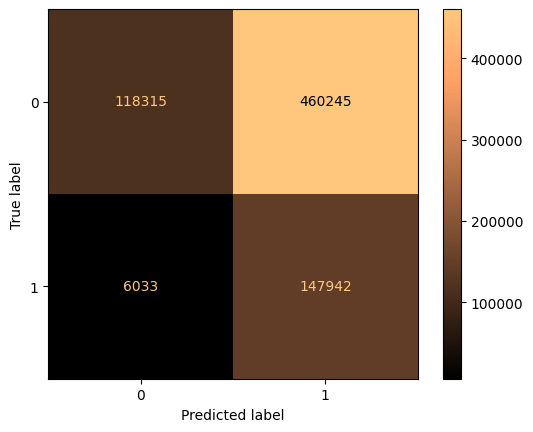

In [25]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test2, y_pred2)).plot(cmap='copper')
plt.show()

Obtaining the `classification report` to assess `K Means Clustering` performance using `precision`, `recall`, and `F1-score`.

In [26]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.20      0.34    578560
           1       0.24      0.96      0.39    153975

    accuracy                           0.36    732535
   macro avg       0.60      0.58      0.36    732535
weighted avg       0.80      0.36      0.35    732535



Calculating the `ROC-AUC Score` for `K Means Clustering`.

In [27]:
roc2 = roc_auc_score(y_test2, y_pred2)
roc2

np.float64(0.5826587079391425)

#### Plotting an `ROC Curve` for `K Means Clustering`.

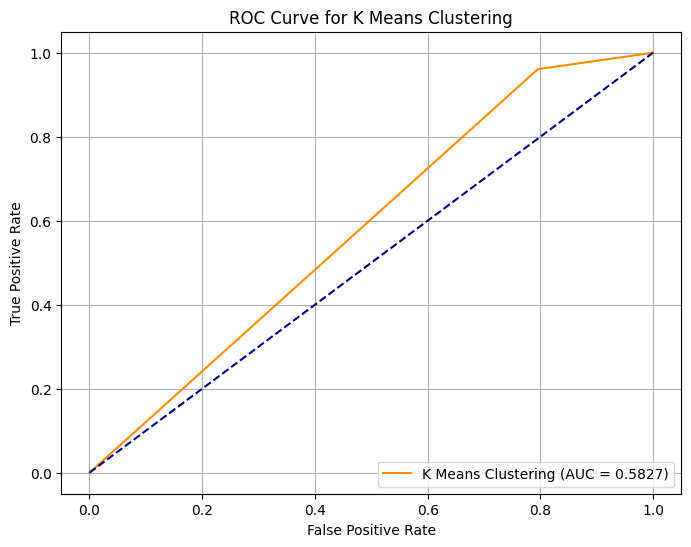

In [28]:
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2)
roc_auc = roc_auc_score(y_test2, y_pred2)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'K Means Clustering (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K Means Clustering')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()